# Alana Viana
# Tarefa Análise de Votos

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("data/eleicoes_2006_TREINO_CONFIGURADO_LIBRE.csv", index_col="nome")
del train['sequencial_candidato']
del train['cargo']
del train['ano']
test = pd.read_csv("data/eleicoes_2010_TESTE_CONFIGURADO_LIBRE.csv", index_col="nome")

del test['sequencial_candidato']
del test['cargo']
del test['ano']
all_data = pd.concat((train.loc[:,'quantidade_doacoes':'votos'], test.loc[:,'quantidade_doacoes':'votos']))

## Pré-Processamento

(tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso).

In [3]:
train["votos"] = np.log1p(train["votos"])

In [4]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [5]:
all_data = pd.get_dummies(all_data) # dummies
all_data = all_data.fillna(all_data.mean()) # valores ausentes

###  Variáveis e métodos auxiliares

In [48]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.votos
y_test = test.votos
# encode knn
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [49]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

In [50]:
def rmse_cv_knn(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train_encoded, scoring = "neg_mean_squared_error", cv = 5 ))
    return (rmse)

In [89]:
type(y_test)

pandas.core.series.Series

In [91]:
y_test = pd.Series(y_test)

In [92]:
y_test

nome
ANTONIA LUCILEIA CRUZ RAMOS CAMARA      15849
DEODATO NUNES DE FRANÇA                  4620
EDSON FIRMINO DE PAULA                    312
ELISABETH APARECIDA GARCIA RODRIGUES     1357
FLAVIANO FLAVIO BAPTISTA DE MELO        36301
                                        ...  
ROBERTO PEREIRA URBANO                   3013
RONALDO DIMAS NOGUEIRA PEREIRA          35980
SÉRGIO PERIN                               20
ÍTALO MARCEL COSTA CONCEIÇÃO              293
LEONAM XAVIER GOMES                      1248
Name: votos, Length: 3942, dtype: int64

## Machine Learning

### Ridge Model

In [60]:
model_ridge = Ridge()
model_ridge.fit(X_train, y_train)
rmse = -cross_val_score(model_ridge, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.8396952789264265

In [65]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] # The higher the regularization the less prone our model will be to overfit
cv_ridge = [rmse_cv (Ridge (alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("rmse Ridge: {}".format(cv_ridge.min()))

rmse Ridge: 0.908512641693385


In [80]:
y_pred_ridge = model_ridge.predict(X_test)

In [81]:
print(type(y_pred_ridge))

<class 'numpy.ndarray'>


In [82]:
y_pred_ridge = pd.Series(y_pred_ridge)

In [83]:
print(type(y_pred_ridge))

<class 'pandas.core.series.Series'>


In [84]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [85]:
print('Acurácia Ridge: ' , accuracy_score(y_test, y_pred_ridge))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [76]:
y_test_s

0        9.801964
1        7.761183
2        7.301783
3        6.387652
4       10.007455
          ...    
3937     7.531124
3938    11.638967
3939     7.245944
3940     7.367502
3941     8.397717
Length: 3942, dtype: float64

In [10]:
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)

In [79]:
y_pred_ridge = model_ridge.predict(X_test)
y_pred_ridge = pd.Series(y_pred_ridge)
print('Acurácia Ridge: ' , accuracy_score(y_test, y_pred_ridge))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [11]:
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " + str(sum(coef_ridge == 0)) + " variables") 

Ridge picked 172 variables and eliminated the other 30 variables


In [12]:
imp_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])

<AxesSubplot:xlabel='preds', ylabel='residuals'>

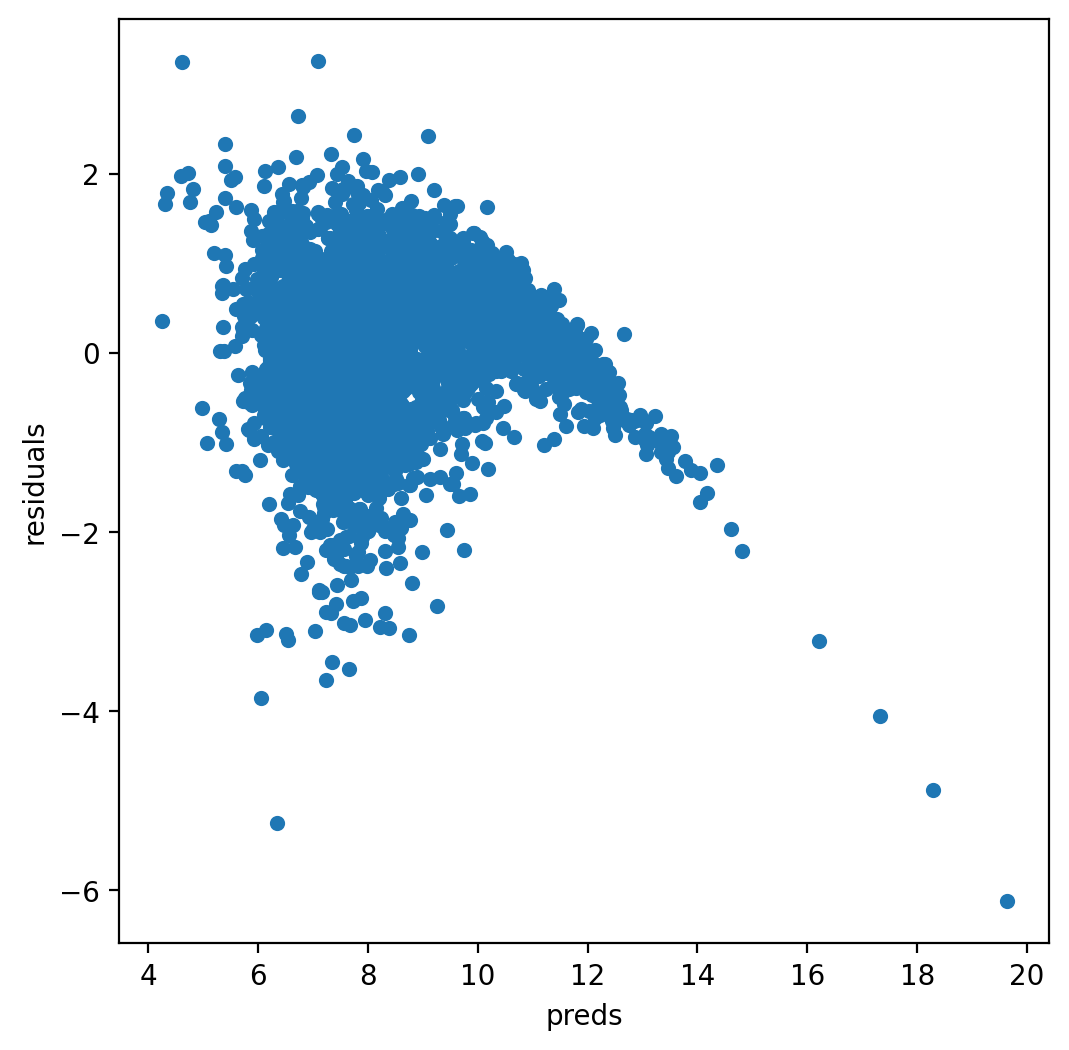

In [14]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### Lassso Model

In [15]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=60000000).fit(X_train, y_train)

In [16]:
print("rmse Lasso: {}".format(rmse_cv(model_lasso).mean()))

rmse Lasso: 0.9101543257964085


In [17]:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [18]:
print("Ridge picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " + str(sum(coef_lasso == 0)) + " variables")

Ridge picked 57 variables and eliminated the other 145 variables


In [19]:
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

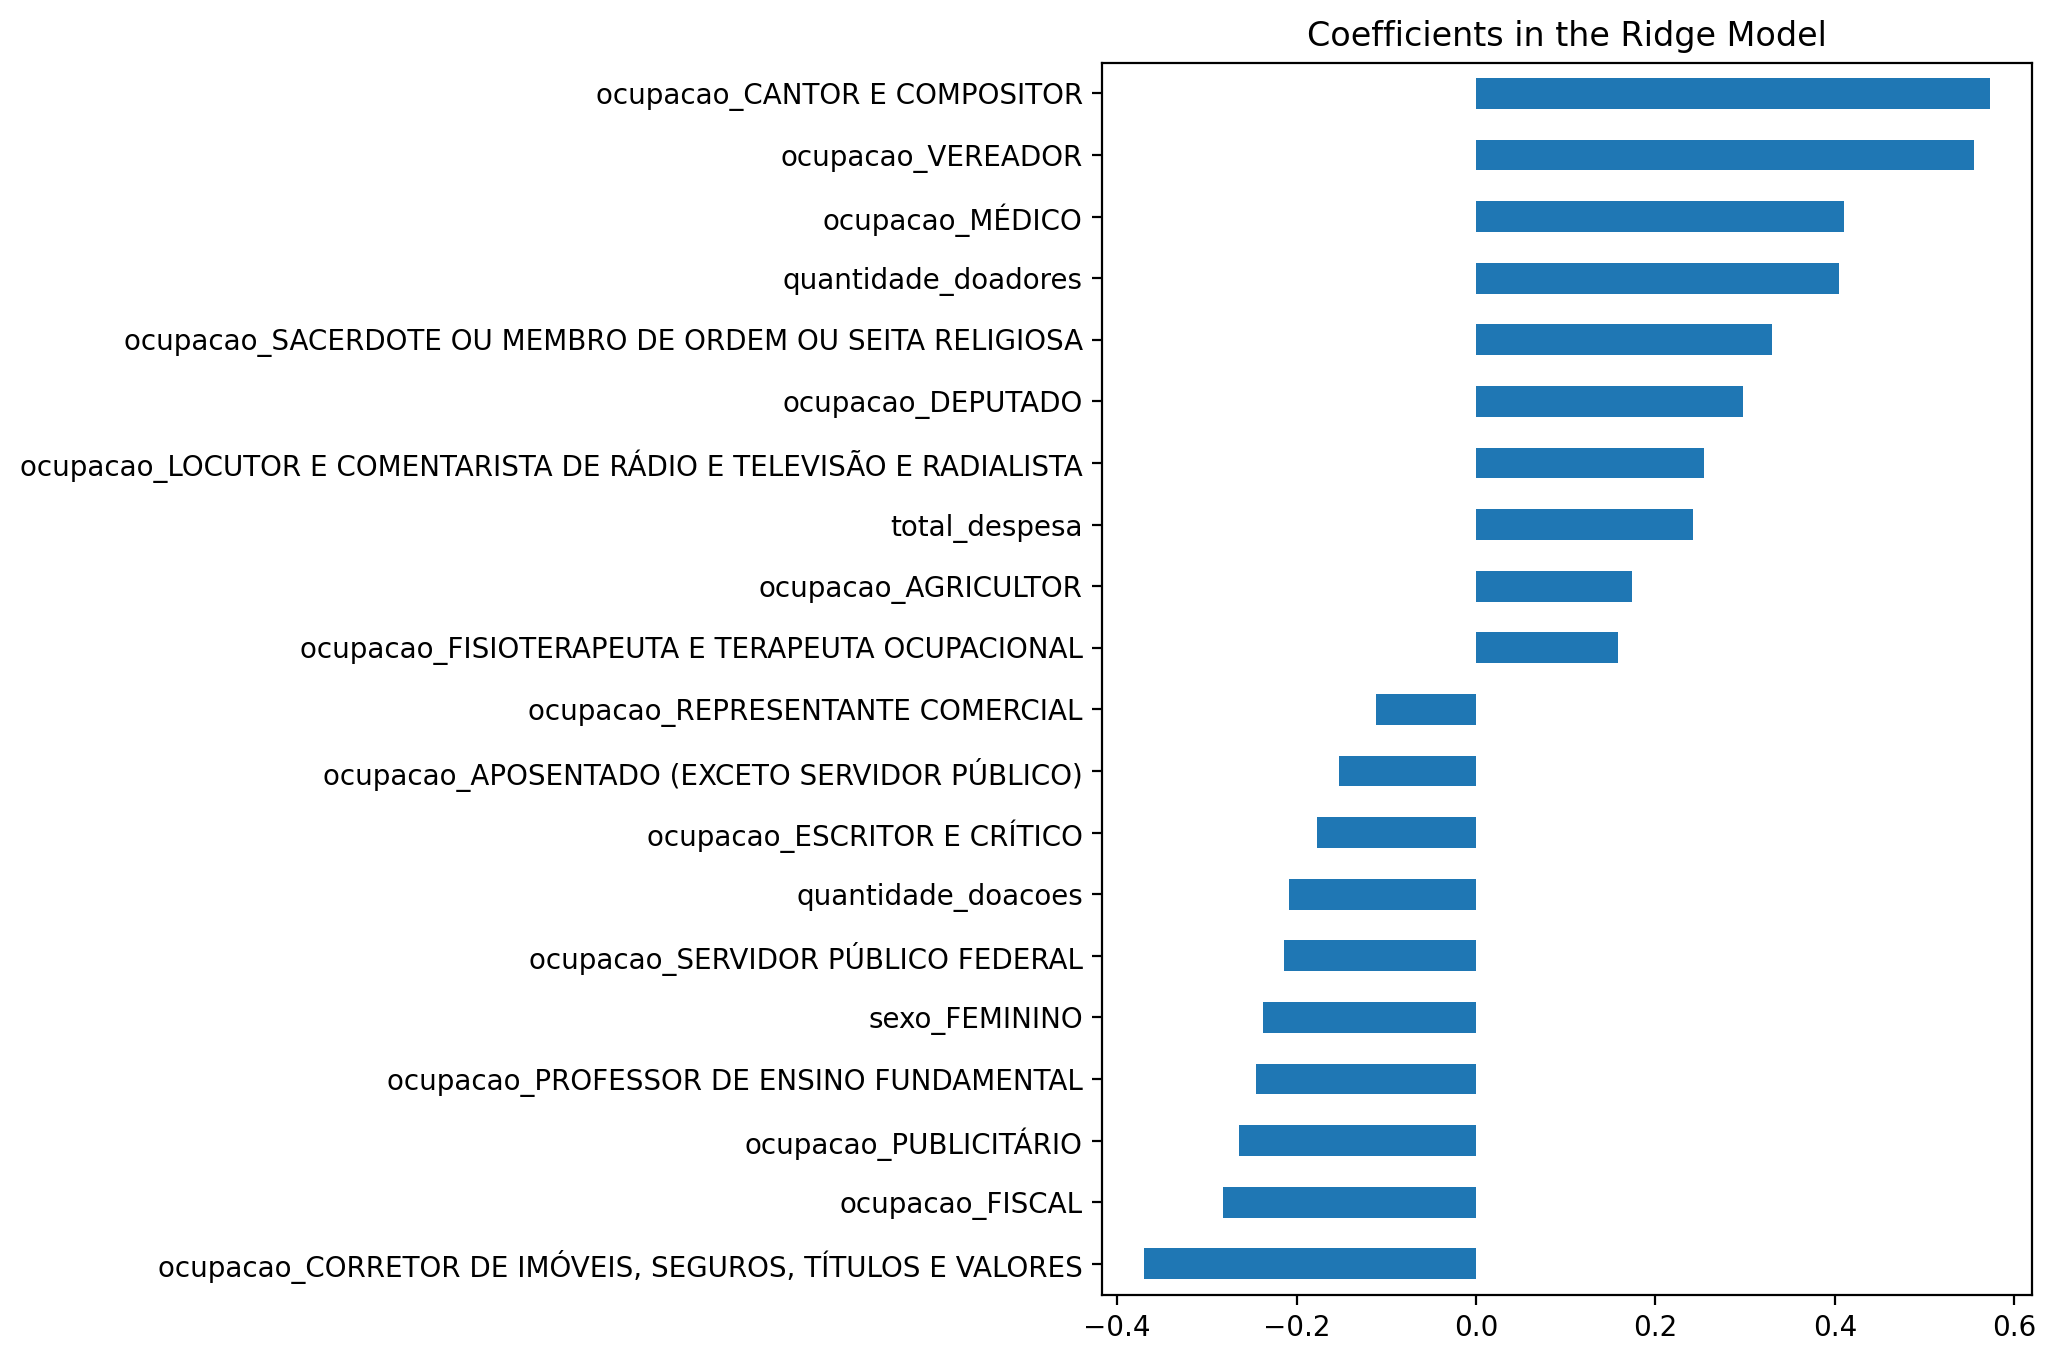

In [20]:
matplotlib.rcParams['figure.figsize'] = (6.0, 8.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

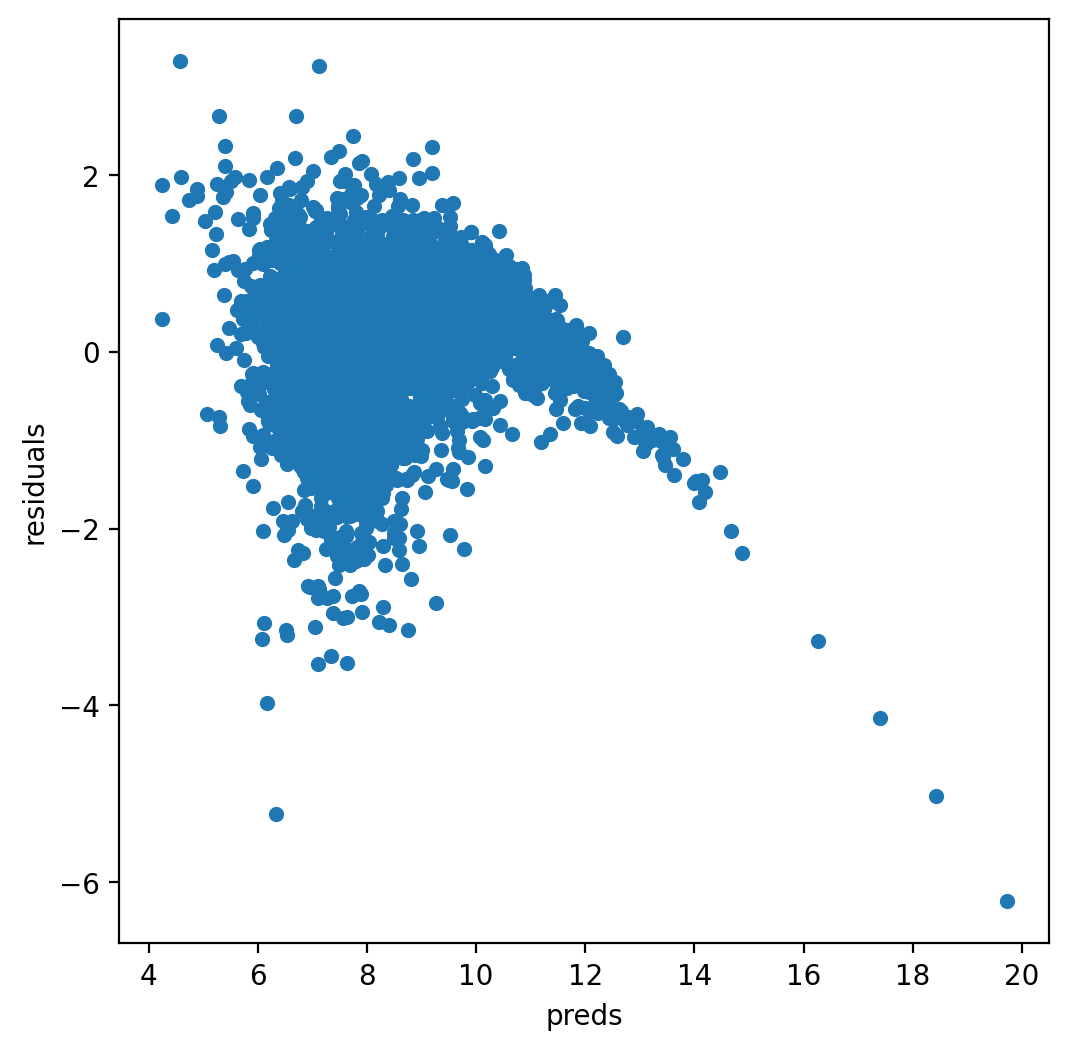

In [21]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### SVR Model

In [221]:
model_svr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_svr.fit(X_train, y_train)
rmse = -cross_val_score(model_svr, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.32393462061202877

In [229]:
model_svr = svm.SVR(kernel='rbf')
model_svr.fit(X_train, y_train)
rmse = -cross_val_score(model_svr, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.32393462061202877

In [230]:
print("rmsr SVR Model: {}".format(rmse_cv(model_svr).mean()))

rmsr SVR Model: 0.5673584323864463


In [231]:
y_pred_svr = model_svr.predict(X_test)

In [232]:
print("acurácia SVR Model: {}".format(accuracy_score(y_test.to_numpy(), y_pred_svr.astype('int64'))))

acurácia SVR Model: 0.0


Dica: No SVR o parâmetro C é um trade off (escolha) entre a incorreta classificação de exemplos de treinamento contra a simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente, dando ao modelo liberdade para selecionar mais amostras como vetores de suporte. O parâmetro gamma define qual é a influência de um único exemplo de treinamento. É um coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'. Se gamma for definido como 'auto' então 1/n_features serão usados. Valores baixos significam 'alta variância' e maior influência do vetor de suporte e valores altos significam 'baixa variância' e os vetores de suporte não possuem grande influência no processo de classificação. Os parâmetros gama podem ser vistos como o inverso do raio de influência de amostras selecionadas pelo modelo como vetores de suporte.

In [233]:
def testar_kernels(kernels):
    for kernel in kernels:
        classifier = svm.SVR(kernel=kernel)
        cv_svr = rmse_cv(classifier).mean()
        cv_svr
        #cv_svr = pd.Series(cv_svr, index = alphas)
        #print("rmse SVR: {}".format(cv_svr.min()))
#['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
# o tempo de processamento do kernel linear é alto em relação aos demais
kernels = ['poly', 'rbf', 'sigmoid']
testar_kernels(kernels)

In [25]:
rmse_cv(model_svr).mean()

0.5673584323864463

<AxesSubplot:xlabel='preds', ylabel='residuals'>

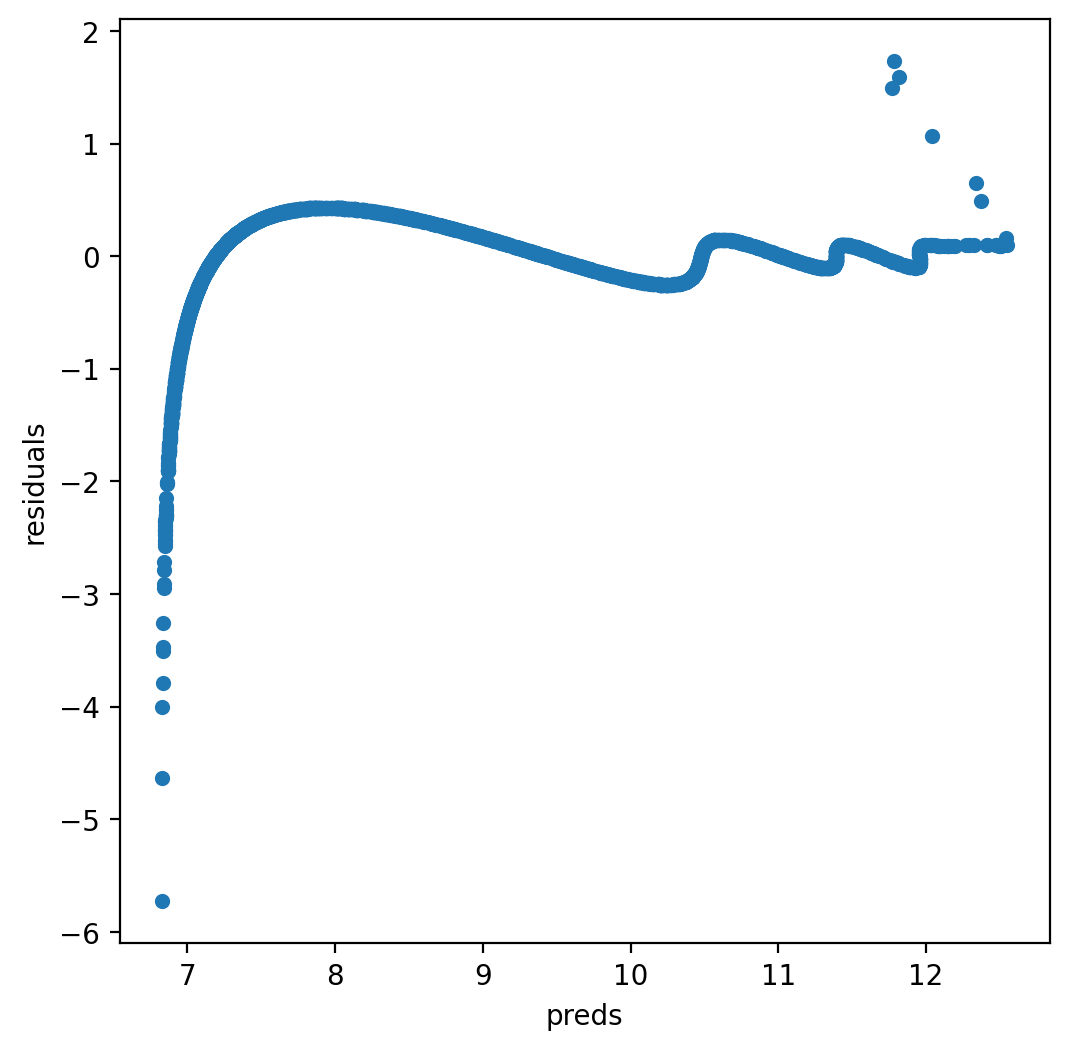

In [26]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_svr.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### RandomForestRegressor Model

In [27]:
model_random = RandomForestRegressor(n_estimators = 50, random_state = 43, max_depth = 8)
model_random.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=50, random_state=43)

In [28]:
rmse = -cross_val_score(model_random, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

0.0013271751134926225

In [29]:
print("rmse Random: {}".format(rmse_cv(model_random).mean()))

rmse Random: 0.029694842573633244


In [234]:
y_pred_random = model_random.predict(X_test) 

In [240]:
accuracy_score(y_test.to_numpy(), y_pred_random.astype("int64"))

0.0

<AxesSubplot:xlabel='preds', ylabel='residuals'>

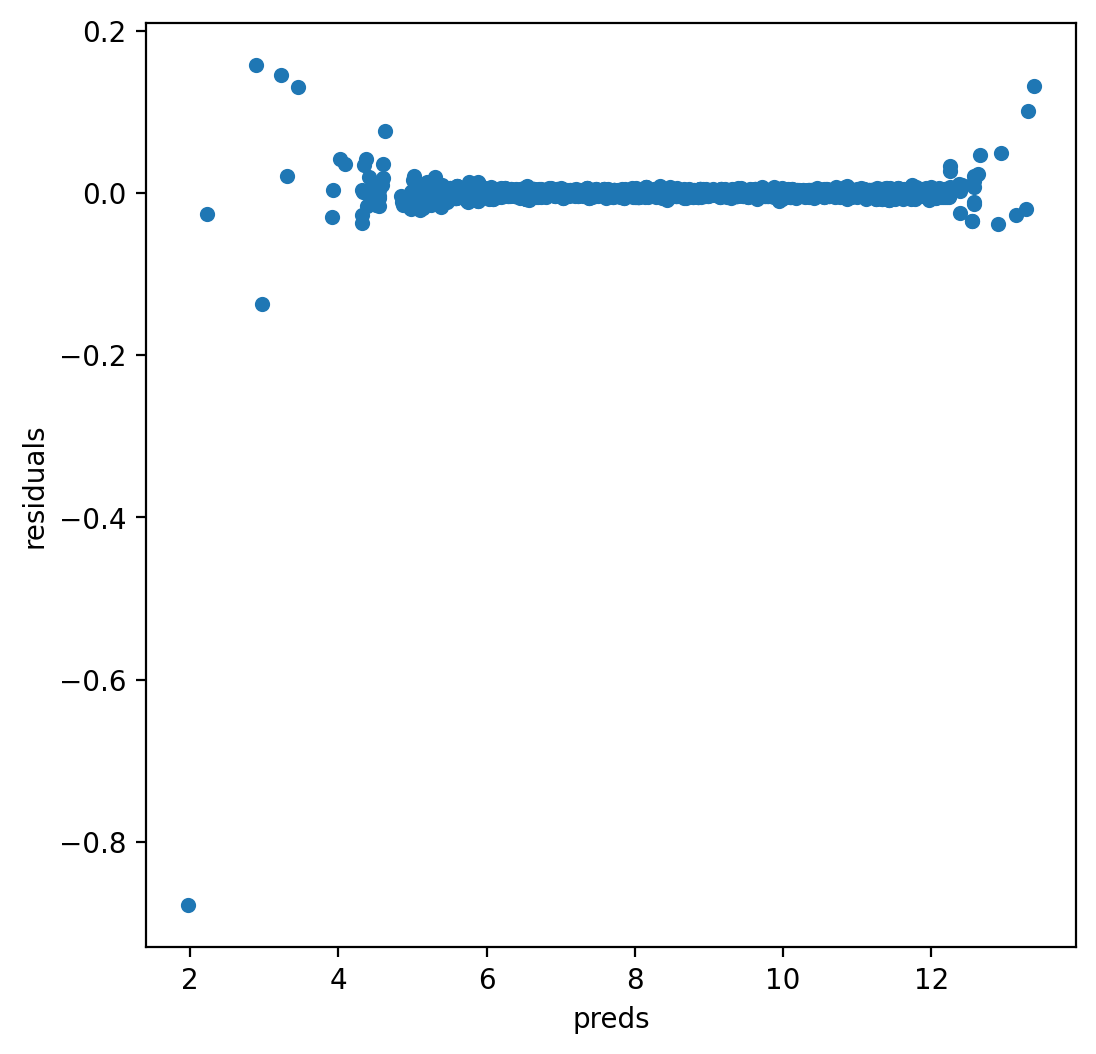

In [241]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_random.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

### KNN Model

In [54]:
model_knn = KNeighborsClassifier(n_neighbors=5)  
model_knn.fit(X_train, y_train_encoded)  

KNeighborsClassifier()

In [55]:
rmse = -cross_val_score(model_knn, X_train, y_train_encoded, scoring = "neg_mean_squared_error", cv = 5 )
rmse.mean()

c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


8.91098983455554

In [56]:
print("rmse Random: {}".format(rmse_cv_knn(model_knn).mean()))

c:\users\gisel\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


rmse Random: 2.9845462193788883


<AxesSubplot:xlabel='preds', ylabel='residuals'>

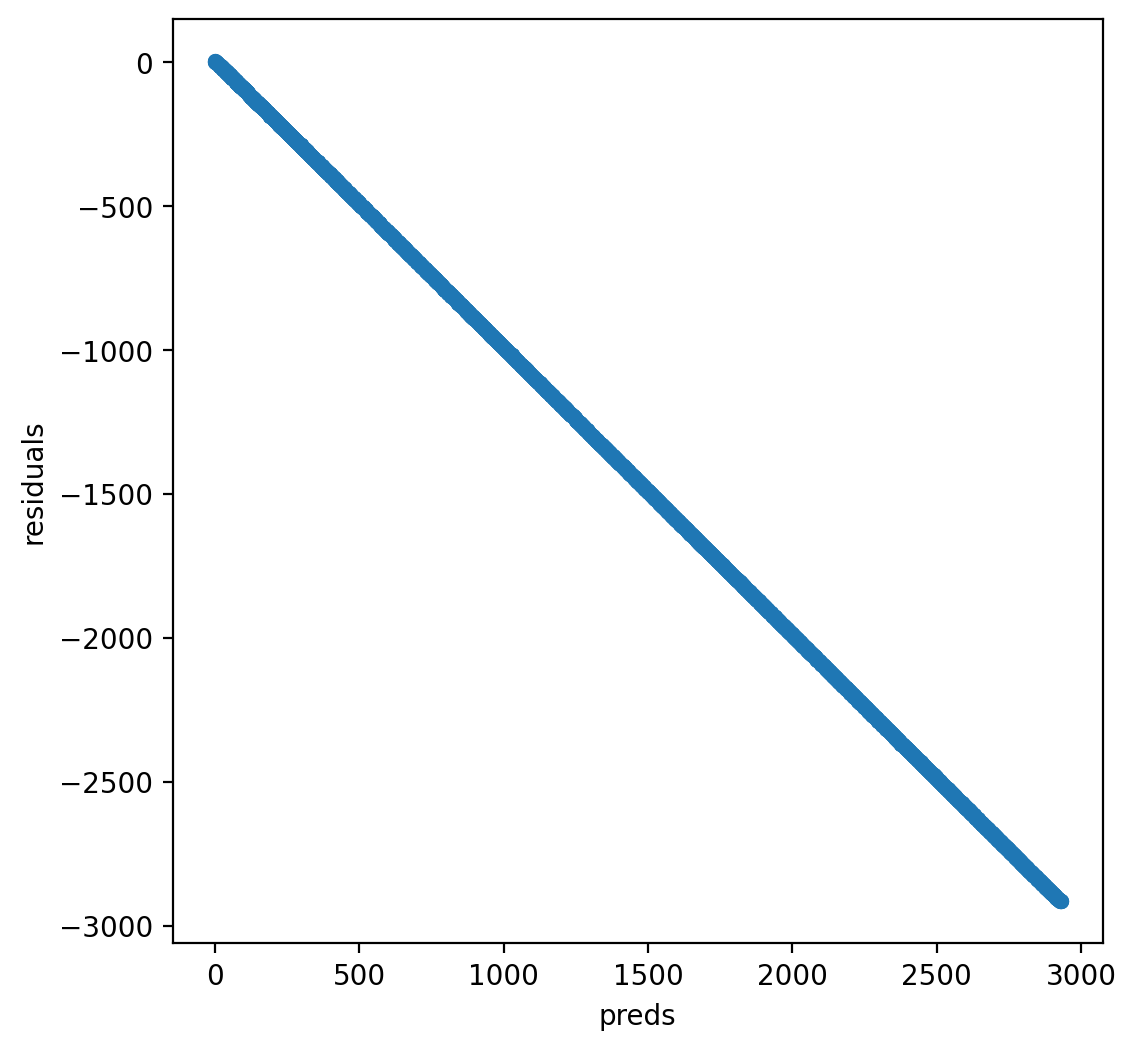

In [57]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_knn.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## Analise dos Resultados

Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta

Entre o RandomForest (rmse=0.02) SVR (rmse=0.32), o Ridge(0.91) e o Lasso(0.32), o melhor modelo foi o RandomForest pois ele tinha um RMSE menor.

## XGBOOST ( em construção )

In [31]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

NameError: name 'y' is not defined

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso":lasso_preds})
predictions = predictions[(np.abs(stats.zscore(predictions)) < 3).all(axis=1)]
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"nome":test.index, "votos":preds})
solution.to_csv("saida.csv", index = False)